**Experiment 2**

In Experiment 1 was a shallow ANN using limited ADNIMERGE MRI dataset, the accuracy was 92% but this could not explain the class imbalance in the Dementia class.

In this python script we attempt to achieve two things. One is to handle class imbalance a bit better and apply resampling technique together with SMOTE.
We also created a simple logistic regression for comparison to justify the use of the Shallow ANN and lastly we began to apply XAI to understand contributory features.

Steps:

1. **Data Loading and Preparation**:
Load data, applied standard scaler and appropriate hot encoding.

2. **Handling Class imbalance**: Applied SMOTE to oversample the minority class in the training data.

3. **Model Building and Training:**Shallow ANN

4. **Model Evaluation** Accuracy, Confusion Matrix, ROC AUC.

5. **Interpretability** SHAP




In [1]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned dataset
df = pd.read_csv("ADNI_baseline_clean.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PTID             2066 non-null   object 
 1   AGE              2066 non-null   float64
 2   APOE4            2066 non-null   float64
 3   Hippocampus      2066 non-null   float64
 4   ICV              2066 non-null   float64
 5   MMSE             2066 non-null   float64
 6   CDRSB            2066 non-null   float64
 7   DX               2066 non-null   object 
 8   Hippocampus_ICV  2066 non-null   float64
dtypes: float64(7), object(2)
memory usage: 145.4+ KB


In [4]:
df.head()

,PTID,AGE,APOE4,Hippocampus,ICV,MMSE,CDRSB,DX,Hippocampus_ICV
0,011_S_0002,74.3,0.0,8336.0,1984660.0,28.0,0.0,CN,0.004200
1,011_S_0003,81.3,1.0,5319.0,1920690.0,20.0,4.5,Dementia,0.002769
2,022_S_0004,67.5,0.0,6869.0,1679440.0,27.0,1.0,MCI,0.004090
3,011_S_0005,73.7,0.0,7075.0,1640770.0,29.0,0.0,CN,0.004312
4,100_S_0006,80.4,0.0,5348.0,1485830.0,25.0,0.5,MCI,0.003599


In [5]:
# Select features
features = ['AGE', 'APOE4', 'Hippocampus_ICV', 'MMSE', 'CDRSB']
X = df[features]
y = df['DX']

In [6]:
X.head()

,AGE,APOE4,Hippocampus_ICV,MMSE,CDRSB
0,74.3,0.0,0.004200,28.0,0.0
1,81.3,1.0,0.002769,20.0,4.5
2,67.5,0.0,0.004090,27.0,1.0
3,73.7,0.0,0.004312,29.0,0.0
4,80.4,0.0,0.003599,25.0,0.5


In [7]:
# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [8]:
# Split into train, validation, and test Before resampling
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [9]:
#Scale only after splitting (fit on training only!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [10]:
from collections import Counter # Import the Counter object from the collections module

print("Class distribution BEFORE SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Class distribution AFTER SMOTE:", Counter(y_train_resampled))

Class distribution BEFORE SMOTE: Counter({np.int64(2): 556, np.int64(0): 480, np.int64(1): 203})
Class distribution AFTER SMOTE: Counter({np.int64(2): 556, np.int64(0): 556, np.int64(1): 556})


In [11]:
# Shallow ANN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
#Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4462 - loss: 1.0049 - val_accuracy: 0.5642 - val_loss: 0.8890
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6991 - loss: 0.7274 - val_accuracy: 0.7143 - val_loss: 0.6986
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7712 - loss: 0.5849 - val_accuracy: 0.7409 - val_loss: 0.5838
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7980 - loss: 0.4940 - val_accuracy: 0.7966 - val_loss: 0.4964
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8296 - loss: 0.4356 - val_accuracy: 0.8087 - val_loss: 0.4487
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8306 - loss: 0.3970 - val_accuracy: 0.8402 - val_loss: 0.4083
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8385 - loss: 0.3852 - val_accuracy: 0.8620 - val_loss: 0.3715
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8356 - loss: 0.3547 - val_accuracy: 0.8668 - v

In [15]:
#Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"\n Test accuracy: {test_acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8911 - loss: 0.2446 

 Test accuracy: 0.9034


In [34]:
# Predict and metrics
y_pred_probs = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Classification Report:
              precision    recall  f1-score   support

          CN       0.96      0.93      0.95       160
    Dementia       0.80      0.88      0.84        68
         MCI       0.90      0.89      0.89       186

    accuracy                           0.90       414
   macro avg       0.89      0.90      0.89       414
weighted avg       0.91      0.90      0.90       414

Confusion Matrix:
[[149   0  11]
 [  0  60   8]
 [  6  15 165]]


In [35]:
#AUC score
try:
    auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    print(f"ROC AUC: {auc:.4f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

ROC AUC: 0.9827


**Model Interpretation and Explainability**
SHAP VALUES: To observe the contributory feature effects and the weights we apply SHAP to explore global relevance and understand if Clinical scores were the most relevant features or if it is he Normalized MRI feature.

In [18]:
pip install shap



🔹 SHAP Summary for class: CN


<ipython-input-36-02bff2e4a448>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, i], X_sample_df, feature_names=features, show=False) # Updated line: Accessing shap_values for the current class


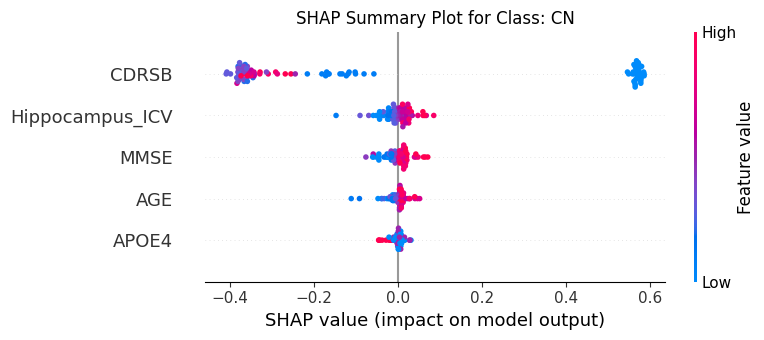


🔹 SHAP Summary for class: Dementia


<ipython-input-36-02bff2e4a448>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, i], X_sample_df, feature_names=features, show=False) # Updated line: Accessing shap_values for the current class


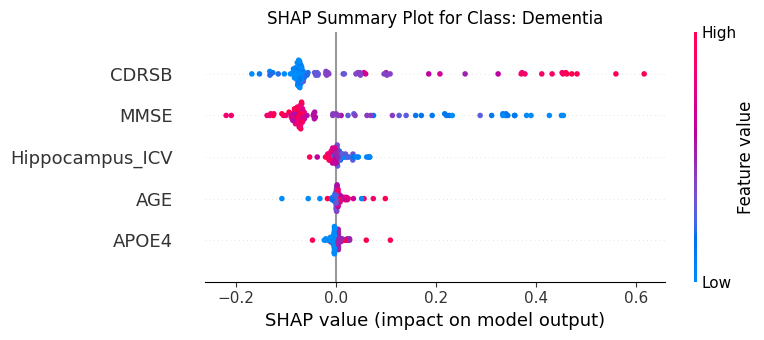


🔹 SHAP Summary for class: MCI


<ipython-input-36-02bff2e4a448>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, i], X_sample_df, feature_names=features, show=False) # Updated line: Accessing shap_values for the current class


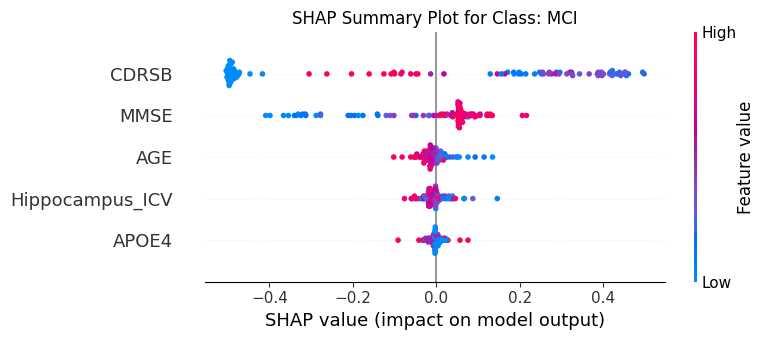

In [36]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

#  Create a DataFrame with feature names
X_sample = X_test_scaled[:100]
X_sample_df = pd.DataFrame(X_sample, columns=features)

# Create SHAP explainer for Keras model
explainer = shap.Explainer(model, X_train_scaled)

# Compute SHAP values
shap_values = explainer(X_sample_df)

# Get actual class names from label encoder
class_names = le.classes_

#  Plot SHAP summary for each class
for i, class_name in enumerate(class_names):
    print(f"\n🔹 SHAP Summary for class: {class_name}")
    # Access the SHAP values for the specific class
    shap.summary_plot(shap_values[:, :, i], X_sample_df, feature_names=features, show=False) # Updated line: Accessing shap_values for the current class
    plt.title(f"SHAP Summary Plot for Class: {class_name}")
    plt.tight_layout()
    plt.show()

In [19]:
#SHAP Explainability for Feature Importance
import shap

ExactExplainer explainer: 101it [00:13,  7.59it/s]                        
<ipython-input-25-71f07d1c3a2c>:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, feature_names=features)


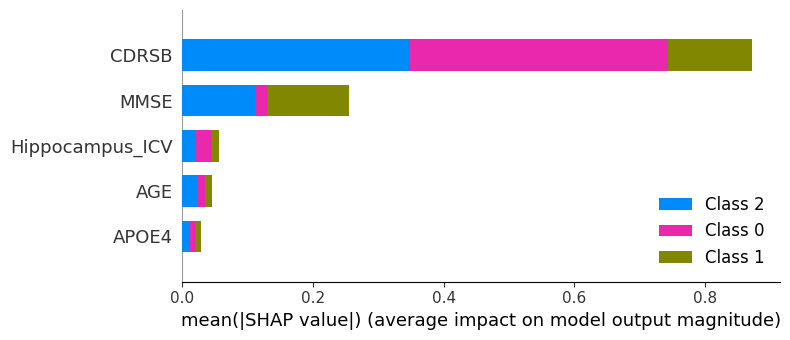

<ipython-input-25-71f07d1c3a2c>:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, feature_names=features, plot_type="bar")


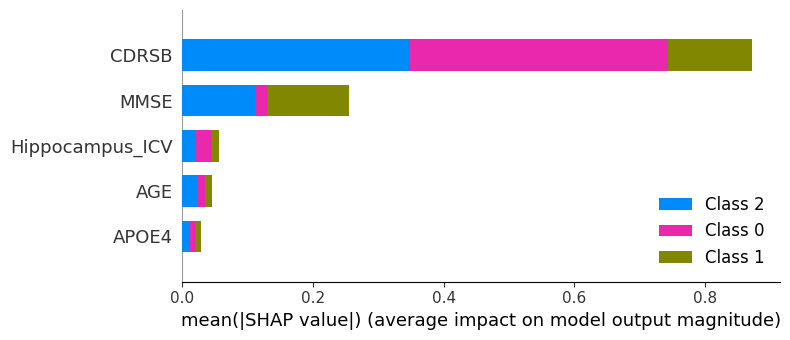

In [25]:
import shap
import matplotlib.pyplot as plt

# Sample a smaller test set for SHAP
X_sample = X_test_scaled[:100]

# Define a SHAP explainer for Keras
explainer = shap.Explainer(model, X_train_scaled)

# 3. Compute SHAP values
shap_values = explainer(X_sample)

# 4. Plot summary (SHAP value magnitude by feature)
shap.summary_plot(shap_values, X_sample, feature_names=features)

# Optional: bar plot to rank feature importance
shap.summary_plot(shap_values, X_sample, feature_names=features, plot_type="bar")


**Model Comparison and Interpretation**

Logistic Regression Model.

The attempt was to compare ANN with simpler models like logistic regression., This is in order to provide justification for the so called Blackbox ANN.





In [21]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression


In [22]:
logreg_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
logreg_model.fit(X_train_resampled, y_train_resampled)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [23]:
# Evaluate on test set
logreg_test_loss, logreg_test_acc = model.evaluate(X_test_scaled, y_test)
print(f"\n Test accuracy: {logreg_test_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9040 - loss: 0.2395  

 Test accuracy: 0.9082


In [24]:
# Predict and metrics for Logistic Regression
y_pred_probs_logreg = logreg_model.predict_proba(X_test_scaled)
y_pred_labels_logreg = logreg_model.predict(X_test_scaled)

In [25]:
print("Logistic Regression - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels_logreg))

Logistic Regression - Confusion Matrix:
[[153   0   7]
 [  0  62   6]
 [  7  15 164]]


In [26]:
# AUC score for Logistic Regression
try:
    auc_logreg = roc_auc_score(y_test, y_pred_probs_logreg, multi_class='ovr')
    print(f"Logistic Regression - ROC AUC: {auc_logreg:.4f}")
except Exception as e:
    print(f"Logistic Regression - ROC AUC not available: {e}")

Logistic Regression - ROC AUC: 0.9864


**Experiment 2 Summary
Model Performance:**

ANN model achieved ~91% accuracy.

SMOTE effectively addressed class imbalance, improving classification, especially for underrepresented classes like Dementia, however there is still rome for improvement as confusion matrix shows a slightly lower prescision and recall in the Dementia class.

Logistic Regression showed comparable accuracy but lacked the same depth in modeling non-linear relationships.




**SHAP Analysis Conclusions:**

CDRSB was consistently the most impactful feature across all classes, aligning well with its known clinical relevance in dementia staging.

MMSE and Hippocampus/ICV ratio also showed strong contributions, particularly for Dementia and MCI.

APOE4 had the least individual impact in the current model, likely due to limited granularity or interaction effects not fully captured by the current architecture.

SHAP analysis provided clear, interpretable feature attribution, validating model decisions and reinforcing the biological plausibility of the ANN’s focus.

**Experiment 3 Plan**

**Goal:** Improve diagnostic prediction by incorporating more detailed neuroimaging markers and optimizing model architecture and sampling.

Planned Steps:

**Feature Expansion:**

Add more MRI-derived biomarkers:

Ventricular Volume, Cortical Thickness etc

These features are clinically meaningful and can enhance class separability, especially for early or subtle cognitive changes.

**Modeling Strategy:**

Build both:

Shallow ANN,
More engineered ANN

Test and compare with classical baselines (e.g., Logistic Regression, Random Forest).

Resampling and Evaluation:

Reassess SMOTE or other hybrid resampling techniques (e.g., ADASYN).

Perform cross-validation to ensure generalizability.

SHAP for feature importance and transparency.